<a href="https://colab.research.google.com/github/vincent-grari/FAGTB/blob/master/FAGTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import of all libraries and functions

In [22]:
from functions import *

Import of the Adult UCI data set

In [23]:
X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) #,'race','race-sex','sex'

Train an unfair GTB:

In [25]:
table = [0,0,0,0]
for k  in range(10):
    np.random.seed()
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['income-per-year','race','race-sex'])
    #X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(3,'race',"two_year_recid",['two_year_recid','sex','sex-race'])
    
    gb = GradientBoostingClassifier(n_estimators=500, learning_rate = 0.05, max_depth = 3, max_features=90,random_state=0,  min_impurity_decrease=0.0, min_impurity_split=None,
      min_samples_leaf=2, min_samples_split=2,
      min_weight_fraction_leaf=0.0,
      presort='auto')
    gb.fit(X_train, y_train)

    ##### Results on Test dataset #####
    y_predt2= gb.predict_proba(X_test.values)[:,1]
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])

np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8710425990386209
PRULE :  30.79728375548528
DI :  0.18373457388738035
DispFPR :  0.06436134204579154
DispFNR :  0.036237505762246935


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8622575832918946
PRULE :  34.28368598268378
DI :  0.16496557203187134
DispFPR :  0.06390782256776185
DispFNR :  0.013923879283764373


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8660699486159457
PRULE :  33.30735007247357
DI :  0.1690684093318902
DispFPR :  0.0528196204481773
DispFNR :  0.04547908232118758


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8680590087850157
PRULE :  26.150002070707767
DI :  0.19745001945113114
DispFPR :  0.07286822817138071
DispFNR :  0.1217948717948718


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8577821979114868
PRULE :  26.922500539129864
DI :  0.19844633153893376
DispFPR :  0.0728813914237971
DispFNR :  0.11463087248322146


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8715398640808885
PRULE :  30.015551005186015
DI :  0.18971075199902337
DispFPR :  0.0720954738157669
DispFNR :  0.10693742553104069


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8722028841372451
PRULE :  34.529380282254486
DI :  0.17063806424951478
DispFPR :  0.047376963685571136
DispFNR :  0.06875529882922682


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8678932537709265
PRULE :  27.796002678714597
DI :  0.19281448588361821
DispFPR :  0.07248457940480188
DispFNR :  0.1433811802232855


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8690535388695508
PRULE :  31.275367284112594
DI :  0.17524613803222389
DispFPR :  0.059406281281281274
DispFNR :  0.001707618577405201


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)



Results on test set :
Accuracy: 0.8644123984750539
PRULE :  32.53779961965015
DI :  0.17919128482729424
DispFPR :  0.06152759568443966
DispFNR :  0.07242063492063489
86.70
30.76
 0.06
 0.07


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(array([11.92280027,  6.14558346,  4.4633758 ,  3.29074199,  2.75661036,
         2.60926371,  2.46805649,  1.87866987,  1.645371  ,  1.69448655,
         1.51644267,  1.32611991,  1.46732712,  1.49802434,  1.36295657,
         1.33839879,  1.25858602,  0.94547438,  1.16035492,  0.85338272,
         0.77356995,  0.94547438,  0.7674305 ,  0.97003215,  0.84110383,
         0.80426717,  0.63850218,  1.0744027 ,  1.00072937,  0.68147829,
         0.89635883,  0.98845049,  1.24630713,  0.54027107,  0.63236273,
         0.74901217,  0.71831495,  0.6139444 ,  0.93933493,  0.60166551,
         0.71217551,  0.60166551,  0.57096829,  0.64464162,  0.79812772,
         0.46659774,  0.54027107,  0.3622272 ,  0.60166551,  0.54027107,
         0.46659774,  0.52185274,  0.46659774,  0.52799219,  0.34994831,
         0.41134275,  0.5157133 ,  0.44817941,  0.59552607,  0.41134275,
         0.46659774,  0.5157133 ,  0.44817941,  0.54641052,  0.35608775,
         0.31311164,  0.35608775,  0.49115552,  0.3

(array([3.15239655e+01, 1.59870621e+01, 1.02378933e+01, 7.36973979e+00,
        3.67843906e+00, 2.72667511e+00, 2.25079313e+00, 1.80063450e+00,
        1.42764593e+00, 1.17041243e+00, 1.05465735e+00, 6.81668777e-01,
        8.48870552e-01, 7.84562177e-01, 5.14467001e-01, 6.04498727e-01,
        5.14467001e-01, 4.63020301e-01, 4.37296951e-01, 4.88743651e-01,
        4.24435276e-01, 4.24435276e-01, 4.24435276e-01, 3.47265226e-01,
        2.82956851e-01, 3.08680201e-01, 2.95818526e-01, 1.92925126e-01,
        2.57233501e-01, 2.82956851e-01, 2.31510151e-01, 1.92925126e-01,
        2.44371826e-01, 2.44371826e-01, 2.05786801e-01, 1.67201775e-01,
        2.44371826e-01, 2.05786801e-01, 2.95818526e-01, 1.41478425e-01,
        2.18648476e-01, 5.65913702e-01, 1.80063450e-01, 1.67201775e-01,
        1.02893400e-01, 2.18648476e-01, 1.80063450e-01, 1.15755075e-01,
        1.28616750e-01, 2.82956851e-01, 1.80063450e-01, 1.41478425e-01,
        1.28616750e-01, 2.05786801e-01, 2.31510151e-01, 2.315101

Text(0.5, 0, '$f(X)$')

Text(0, 0.5, '$p(f(X))$')

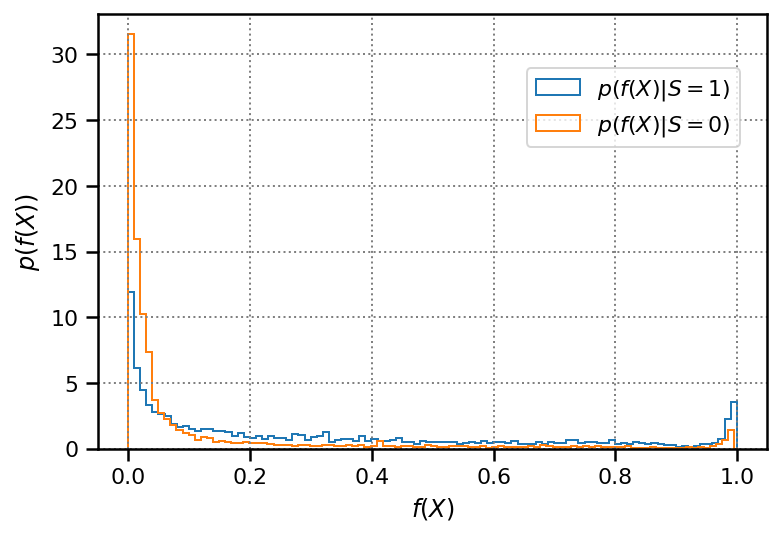

Text(0.5, 1.0, 'Unfair model (FAGTB with   =0.000)')

<Figure size 432x432 with 0 Axes>

In [43]:
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

y_pred_S1=gb.predict_proba(X_train)[:,1][sensitive==1]
y_pred_S0=gb.predict_proba(X_train)[:,1][sensitive==0]

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0
ax1.hist(y_pred_S1, bins=100, density=1, histtype="step", label="$p(f(X)|S=1)$")
ax1.hist(y_pred_S0, bins=100, density=1, histtype="step", label="$p(f(X)|S=0)$")
leg = plt.legend(loc="best")
#plt.ylim(0,15)
plt.xlabel("$f(X)$")
plt.ylabel("$p(f(X))$")
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.8, 0.9),shadow=False, ncol=1)
plt.show()
plt.title('Unfair model (FAGTB with   =0.000)')
plt.savefig("test.pdf" , bbox_inches='tight')
plt.clf() 

plt.show()


Train the FAGTB algorithm on 10 iterations:

In [ ]:
table = [0,0,0,0]

for i in range(5):
    X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['sex','income-per-year','race-sex']) 
   
    classifier= FAGTB(n_estimators=260, learning_rate = 0.01, max_depth = 10,min_samples_split=1.0, min_impurity =False, max_features =20, regression =1)
    y_pred = classifier.fit(X_train.values, y_train.values, sensitive, LAMBDA=0.165, Xtest=X_test.values, yt=y_test,
                      sensitivet=sensitivet)
    
    ##### Results on Test dataset #####
    y_predt2 = classifier.predict(X_test.values)
    print('')
    print('Results on test set :')
    Res = display_results(y_predt2, y_test.values, sensitivet)
    table = np.vstack([table,[Res['Accuracy']*100,Res['PRULE'],Res['DispFPR'],Res['DispFNR']]])
np.savetxt(sys.stdout, np.mean(table[1:,], axis=0).astype(float), '%5.2f')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


0 17023.240944507754 13599.976734092405 16408.811489936183 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


5 51749.92369028452 13519.342530153855 22058.079939050804 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


10 9088.24792124921 13437.593867356565 14937.154774362685 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


15 26302.313197690142 13375.471501050522 17715.353178669397 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encounter

20 5479.264236558545 13297.946912661504 14202.025511693662 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


25 41576.18318972277 13214.082091154745 20074.152317459 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


30 36347.59041819427 13126.791654196935 19124.14407319899 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


35 19601.705304178686 13060.098267200725 16294.37964239021 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encounter

40 57370.72811580056 12994.656779090219 22460.826918197312 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


45 3737.5376877459116 12929.19602253458 13545.889741012657 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


50 5310.362228330966 12863.090443972294 13739.300211646905 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


55 1011.8665664270541 12782.40632026676 12949.364303727225 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encounter

60 40904.00352389267 12707.484427421905 19456.645008864194 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


65 46410.17854219058 12629.218805746244 20286.89826520769 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


70 18959.244143405744 12575.17315337296 15703.448437034907 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


75 60806.35505283333 12522.215192278545 22555.26377599605 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


80 10000.255203928049 12470.618897640968 14120.661006289098 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


85 61269.43814591969 12428.45677538875 22537.914069465496 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


90 14281.438934756874 12376.814347238964 14733.251771473848 Accuracy: 0.7482  test :  0.7626  Prule Train :  nan  Prule test :  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in doub

95 3348.8462532743724 12333.49384006758 12886.053471857851 Accuracy: 0.7489  test :  0.7638  Prule Train :  0.0  Prule test :  0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


100 46344.38496358489 12273.89095273946 19920.71447173097 Accuracy: 0.7511  test :  0.7653  Prule Train :  0.0  Prule test :  0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as ap

105 50006.06467355164 12210.617185930107 20461.617857066125 Accuracy: 0.7523  test :  0.7658  Prule Train :  0.0  Prule test :  0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as ap

110 20161.187234539175 12173.500507911542 15500.096401610506 Accuracy: 0.7542  test :  0.7668  Prule Train :  0.0  Prule test :  0.0


KeyboardInterrupt: ignored

In [ ]:
np.set_printoptions(suppress=True) 
np.mean(table[1:,], axis=0).astype(float)

TypeError: ignored